In [2]:
import os
import numpy as np
import tensorflow as tf
import scipy.io as scio
import matplotlib.pyplot as plt
%matplotlib notebook

class SVHN():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = np.array([])
        self._training_labels = np.array([])
        self._test_data = np.array([])
        self._test_labels = np.array([])
        
        self._load_traing_data()
        #self._load_test_data()
        
        np.random.seed(0)
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
    
    
    def _load_traing_data(self):
        self._training_data, self._training_labels = self._load_data("train_32x32.mat")        
    
    def _load_test_data(self):
        self._test_data, self._test_labels = self._load_data("test_32x32.mat")
    
    def _rgb2gray(self, rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
    def _load_data(self, file):
        path = os.path.join(self._directory, file)
        
        mat = scio.loadmat(path)
        data = np.moveaxis(mat["X"], 3, 0)
        data = self._rgb2gray(data)
        data = data.reshape(data.shape + (1,))
        
        labels = mat["y"].reshape(mat["y"].shape[0])
        labels[labels == 10] = 0
        
        return data, labels
    
    def get_training_batch(self, batch_size):
        return self._get_batch(self._training_data, self._training_labels, batch_size)
    
    def get_validation_batch(self, batch_size):
        return self._get_batch(self._validation_data, self._validation_labels, batch_size)
    
    #def get_test_batch(self, batch_size):
    #    return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    

In [3]:
#LOAD THE DATA

cwd = os.getcwd()
svhn_data = SVHN(cwd)


<IPython.core.display.Javascript object>


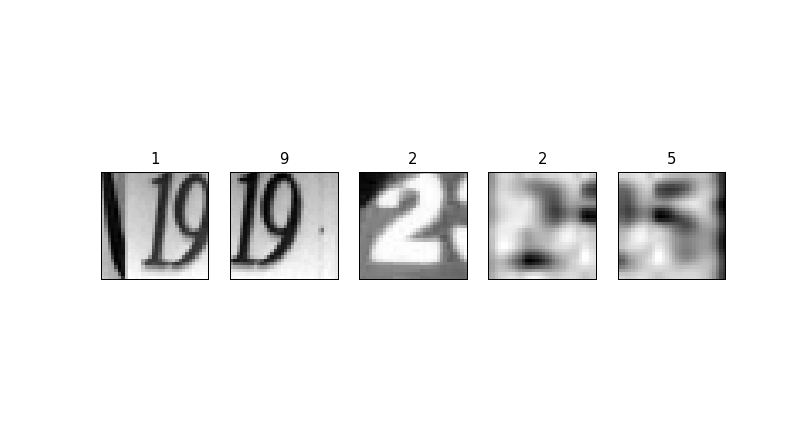

In [4]:
plotting_samples = svhn_data._training_data[:5]
plotting_labels = svhn_data._training_labels[:5]

fig = plt.figure(figsize = (9,5))

for i in range(len(plotting_samples)):
    fig.add_subplot(1,5,i+1)
    plotting_sample = np.squeeze(plotting_samples[i])
    plt.imshow(plotting_sample, cmap='gray')
    plt.title(plotting_labels[i])
    plt.xticks([], [])
    plt.yticks([], [])

plt.show()

In [5]:
#TRAINING PARAMETERS
learning_rate = 0.001
batch_size = 50
epochs = 10

In [6]:
#HYPERPARAMETERS

kernel_size = 5
channels_in = 1 #working with gray value images
image_size = 32 #32x32 pics
nr_classes = 10 #classifying between 10 classes

dropout_rate = 0.75

#channel_out of convolutional layer
conv1_out = 8
conv2_out = 16
conv3_out = 32

nr_hidden = 128 #nr of hiddden neurons in readout layer

#parameters for batch normalization
norm_beta = 0.0
norm_gamma = 1.0
norm_epsilon = 0.001







In [7]:
#FUNCTIONS TO GET BIAS AND WEIGHTS VARIABLES

def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

#biases for convolutional layer
def get_conv_biases(shape):
    return tf.Variable(tf.constant(1.0, shape=shape))

#biases for fully connected layer
def get_fc_biases(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))



In [8]:
#FUNCTIONS FOR BUILDING BLOCKS

def fully_connected(x, weights, biases):
    return tf.matmul(x, weights) + biases
    

def convolution(x, weights, biases):
    conv = tf.nn.conv2d(x, weights, strides=[1, 1, 1, 1], padding="SAME")
    return tf.nn.relu(conv + biases)
    

#2x2/2 maxpooling with same padding
def max_pooling(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding="SAME")
    
#batch normalization
def batch_normalize(x):
    mean, var = tf.nn.moments(x, [1, 2, 3], keep_dims=True)
    return tf.nn.batch_normalization(x, mean, var, norm_beta, 
                                    norm_gamma, norm_epsilon)


    

In [9]:
#INITIALIZE WEIGHTS AND BIASES

weights = {
    "conv1": get_weights([kernel_size, kernel_size, channels_in, conv1_out]),
    "conv2": get_weights([kernel_size, kernel_size, conv1_out, conv2_out]),
    "conv3": get_weights([kernel_size, kernel_size, conv2_out, conv3_out]),
    "fc1": get_weights([(image_size // 8)**2 * conv3_out, nr_hidden]),
    "fc2": get_weights([nr_hidden, nr_classes])
}

biases = {
    "conv1": get_conv_biases([conv1_out]),
    "conv2": get_conv_biases([conv2_out]),
    "conv3": get_conv_biases([conv3_out]),
    "fc1": get_fc_biases([nr_hidden]),
    "fc2": get_fc_biases([nr_classes])
}


In [10]:
#THE NETWORK


def network(x):
    
    normalized = batch_normalize(x)
    
    conv1 = convolution(normalized, weights["conv1"], biases["conv1"])
    max1 = max_pooling(conv1)
    
    conv2 = convolution(max1, weights["conv2"], biases["conv2"])
    max2 = max_pooling(conv2)
    
    conv3 = convolution(max2, weights["conv3"], biases["conv3"])
    max3 = max_pooling(conv3)
    
    shape = max3.get_shape().as_list()
    flattened = tf.reshape(max3, [-1, shape[1] * shape[2] * shape[3]])
    
    fc1 = tf.nn.relu(fully_connected(flattened, weights["fc1"], biases["fc1"]))
    dropout = tf.nn.dropout(fc1, dropout_rate)
    
    fc2 = fully_connected(dropout, weights["fc2"], biases["fc2"])
    
    return fc2    




In [12]:
#INPUT AND OUTPUT OF NETWORK

images = tf.placeholder(tf.float32, [None, image_size, image_size, channels_in])
labels = tf.placeholder(tf.int64, [None])

logits = network(images)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(logits, 1), labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



<IPython.core.display.Javascript object>


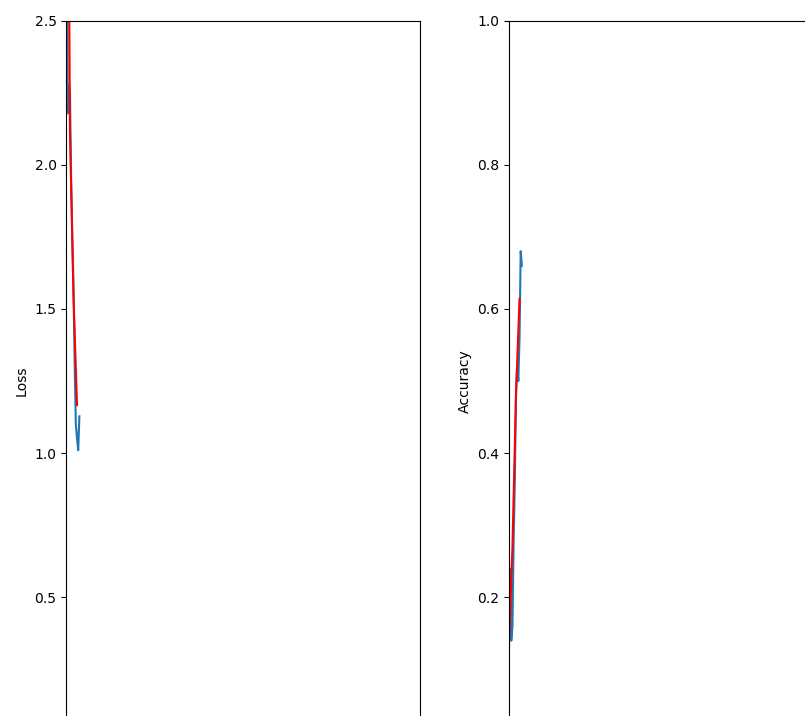

KeyboardInterrupt: 

In [25]:
#RUNNING THE SESSION

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    step = 0
    display_steps = 50
    save_steps = 150
    train_losses = []
    display_losses = []
    train_accuracies = []
    display_accuracies = []
    train_steps = []
    val_losses = []
    val_accuracies = []
    max_val_acc = 0
    val_steps = []
    
    
    fig = plt.figure(figsize=(9,8))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.axis([0,15000,0,2.5])
    ax1.set_xlabel("Training Steps")
    ax1.set_ylabel("Loss")
    ax2.axis([0,15000,0,1])
    ax2.set_xlabel("Training Steps")
    ax2.set_ylabel("Accuracy")
    plot1, = ax1.plot(train_steps,train_losses)
    plot1b, = ax1.plot(val_steps, val_losses, 'r')
    plot2, = ax2.plot(train_steps,train_accuracies)
    plot2b, = ax2.plot(val_steps, val_accuracies, 'r')
    
    
    plt.tight_layout()
    plt.show()
    
    
    for epoch in range(epochs):
        #get batch generator
        batch_generator = svhn_data.get_training_batch(batch_size)
        saver = tf.train.Saver()
        
        for i, batch in enumerate(batch_generator):
            
            images_inp = batch[0]
            labels_inp = batch[1]
           
            _loss, _acc, _ = sess.run(
                                [loss, accuracy, optimizer],
                                feed_dict={images:images_inp,
                                          labels:labels_inp})
            
            
            
            if step%save_steps == 0:
                
                              
                #validate the net
                validation_batch_generator = svhn_data.get_validation_batch(-1) #all data in the batch
               
                for val_batch in validation_batch_generator:
                    
                     _val_loss, _val_acc = sess.run(
                                [loss, accuracy],
                                feed_dict={images:val_batch[0],
                                          labels:val_batch[1]})
                        
                if _val_acc > max_val_acc:
                    saver.save(sess, "./weights/svhn.ckpt", global_step = step)
                    max_val_acc = _val_acc
                                           
                val_steps.append(step)
                val_losses.append(_val_loss)
                val_accuracies.append(_val_acc)
                                        
                
                plot1b.set_xdata(val_steps)
                plot1b.set_ydata(val_losses)
                plot2b.set_xdata(val_steps)
                plot2b.set_ydata(val_accuracies)
                
                
                fig.canvas.draw()
                    
                
            
            
            
            
            
            
            
            if step%display_steps == 0:
            
                display_losses.append(
                    _loss
                )
                
                display_accuracies.append(
                   _acc
                )
                
                train_steps.append(step)
            
                plot1.set_xdata(train_steps)
                plot1.set_ydata(display_losses)
                plot2.set_xdata(train_steps)
                plot2.set_ydata(display_accuracies)
            
                fig.canvas.draw()
                
            step +=1
            
  
        

In [1]:
with tf.Session() as session:
    saver = tf.train.Saver()
    saver.restore(session,  tf.train.latest_checkpoint("./weights/"))
    
    test_accuracy = 0
    for step, (images_inp, labels_inp) in enumerate(svhn_data.get_test_batch(300)):
        test_accuracy += session.run(
            accuracy,
            feed_dict = {images: images_inp, labels: labels_inp}
        )
        
print("Test Accuracy: " + str(test_accuracy / step))


NameError: name 'tf' is not defined